# Hebbian Learning

In [7]:
import numpy as np  # Fast math and arrays
import matplotlib.pyplot as plt  # Displays
import matplotlib.colors as colors  # colors
import matplotlib.cm as cmx  # Colormaps
%matplotlib inline  

## Classic conditioning with Hebb rule

This is a model of the classic experiment whereby the eyeblink response a rabbit, normally elicited by _unconditioned stimulus_ of an air puff,  becomes a _conditioned response_ to a the _conditioned stimulus_ of a tone. 

First, the network setup

In [4]:
tone = 1
swab = 1
blink = 1

no_tone = 0
no_swab = 0
no_blink = 0

x_tone = 0
x_swab = 0
y_blink = 0

w_tb = 0
w_pb = 1

eta = 0.025
gamma = 4

p_conditioning = [tone, swab] 
p_test = [tone, no_swab] 


Then, the simulations:

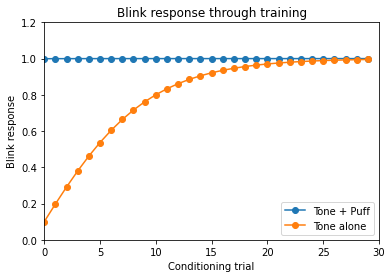

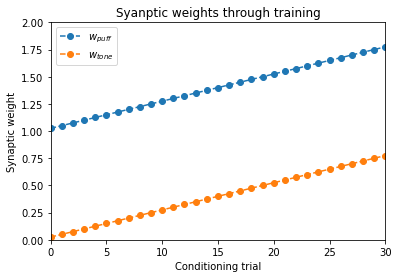

In [5]:
# Conditioning network


def set_inputs(p):
    """Sets the input"""
    global x_tone
    global x_swab
    
    x_tone = p[0]
    x_swab = p[1]

def activation():
    """Calculates activation"""
    global y_blink
    y_blink = np.tanh(gamma * (w_tb * x_tone + w_pb * x_swab))
    
def hebb():
    """Updates synaptic weights"""
    global w_pb
    global w_tb
    w_pb += eta * x_swab * y_blink
    w_tb += eta * x_tone * y_blink
    
train = []
test = []
w_pb_history = []
w_tb_history = []

def hebb_train(n = 30):
    """Conditioning paradigm"""
    for j in range(n):
        set_inputs(p_conditioning)
        activation()
        train.append(y_blink)
        
        hebb()
        
        set_inputs(p_test)
        activation()
        test.append(y_blink)
        
        w_pb_history.append(w_pb)
        w_tb_history.append(w_tb)


hebb_train()
plt.plot(train, "o-")
plt.plot(test, "o-")
plt.xlabel("Conditioning trial")
plt.ylabel("Blink response")
plt.title("Blink response through training")
plt.legend(["Tone + Puff", "Tone alone"], loc="best")
plt.axis([0, 30, 0, 1.2])
plt.show()


hebb_train()
plt.plot(w_pb_history, "o--")
plt.plot(w_tb_history, "o--")
plt.xlabel("Conditioning trial")
plt.ylabel("Synaptic weight")
plt.title("Syanptic weights through training")
plt.legend([r"$w_{puff}$", r"$w_{tone}$"], loc="best")
plt.axis([0, 30, 0, 2.0])
plt.show()

### Oja's rule

Oja's rule essentially adapts the weight matrix to extract the principal component of a number of vectors. Oja's rule is expressed as:

$$\Delta \mathbf{W} = \eta \mathbf{y} \times (\mathbf{x} - \mathbf{W} \mathbf{y}) $$

Here are the parameters

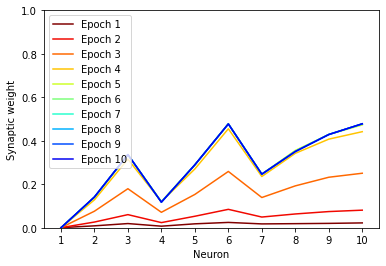

In [12]:
nx = 10
x = np.zeros((1, nx))
w = np.random.random(x.shape)/100
y = 0.0
eta = 0.05


def generate_patterns(n=6):
    """Generates binary patterns"""
    patterns = []
    scale = np.array(np.arange(0.5, 2.0, 1.5/nx))
    scale = scale.reshape((1, nx))
    for i in range(n):
        p = np.random.random(x.shape)
        p *= scale
        p = np.round(p)
        patterns.append(p)
    return patterns

def set_inputs(p):
    global x
    x = np.array(p).reshape((1, nx))

def calculate_response(p):
    global y
    set_inputs(p)
    y = activation()
    return y

def activation():
    return x.dot(w.T)

w_history = []

def oja(epochs=200):
    """Oja's rule"""
    global w, y
    for i in np.arange(epochs):
        for p in patterns:
            y = calculate_response(p)
            dw = eta * y * (x - w * y)
            w = w + dw
        w_history.append(w)


jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin = 0, vmax = 10)
scalarMap = cmx.ScalarMappable(norm = cNorm, cmap = jet)

patterns = generate_patterns()
oja(10)
#print w_history
for i in range(10):
    plt.plot(w_history[i].tolist()[0], color = scalarMap.to_rgba(10-i))
plt.ylabel("Synaptic weight")
plt.xlabel("Neuron")
plt.axis([-0.5, nx - 1/2, 0, 1])
plt.xticks(range(nx), ["%s" % (x+1) for x in range(nx)])
plt.legend(["Epoch %s" % (x+1) for x in range(10)], loc="best")
plt.show()